In [53]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

import time
from IPython.display import clear_output

In [54]:
def varAnalysis(X, verbose=False):
    V = np.var(X, axis=0)
    V_avg, V_std = np.mean(V), np.std(V)
    V_max, V_min = np.max(V), np.min(V)
    
    if verbose == True:
        print(f"V_avg: {np.mean(V):.3f}")    
        print(f"V_std: {np.std(V):.3f}")
        print(f"V_max: {np.max(V):.3f}")
        print(f"V_min: {np.min(V):.3f}")
    
    return V_avg, V_std, V_max, V_min

def plot_V_info(V_info):
    """[summary]

    Args:
        V_info (dict[np.ndarray]): [description]
    """
    global fig, ax
    figscale, defaultSize = 2, np.array([8, 6])
    fig, ax = plt.subplots(nrows=2, ncols=2 ,figsize=figscale*defaultSize)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4, left = 0.1, right = 0.7, bottom = 0.1, top = 0.9) 
    
    ax[0,0].hist(V_info["avg"])
    ax[0,0].set(xlabel="V_avg", ylabel="batches", title="Avg(Var)")
    
    ax[1,0].hist(V_info["std"])
    ax[1,0].set(xlabel="V_std", ylabel="batches", title="Std(Var)")

    ax[0,1].hist(V_info["max"])
    ax[0,1].set(xlabel="V_max", ylabel="batches", title="Max(Var)")

    ax[1,1].hist(V_info["min"])
    ax[1,1].set(xlabel="V_min", ylabel="batches", title="Min(Var)")
    plt.show()

----

## Process Targets

The mice were scored on a test and grouped into 3 categories: GT, IR, and ST. GT was the worst and ST was the best.

In [59]:
def getTargets():
    """Retrives the target matrix from "targets.csv".

    Returns:
        Y (np.ndarray): Phenotype values to be predicted by ML model. 
        names (np.ndarray): The names of the rats.
    """
    df = pd.read_csv("targets.csv")

    # Check if targets.csv contains the same IDs as the feature matrix
    targetRatIDs = df.loc[(df["Vendor"] == "Charles River")][["RatID", "Phenotype"]].values
    miceIDs = np.array(data.columns)[1:].astype(int)
    assert len((a:=set(targetRatIDs[:, 0])).intersection((b:=set(miceIDs)))) == 1780

    # Remove uncommon elements
    for number in a.difference(b):
        targetRatIDs[:, 0] = np.where((targetRatIDs[:, 0] == number), None, targetRatIDs[:, 0])    
    targetRatIDs = pd.DataFrame(targetRatIDs, columns=["RatID", "Phenotype"]).dropna()
    assert targetRatIDs.shape[0] == 1780

    targetRatIDs = targetRatIDs.set_index("RatID").sort_index()
    miceIDs.sort()
    assert np.all(targetRatIDs.index.values == miceIDs.astype(int))

    targetRatIDs = targetRatIDs.astype(str)
    targetRatIDs["Phenotype"].value_counts()

    for i, pt in enumerate(targetRatIDs.Phenotype.values):
        if 'GT' in pt:
            targetRatIDs.Phenotype.iloc[i] = '0'
        if 'IR' in pt:
            targetRatIDs.Phenotype.iloc[i] = '1'
        if 'ST' in pt:
            targetRatIDs.Phenotype.iloc[i] = '2'

    assert len(targetRatIDs.Phenotype.value_counts()) == 3
    
    Y = targetRatIDs.Phenotype.values.astype(int).reshape(-1, 1)
    names = np.array(list(targetRatIDs.index))

    assert X.shape[0] == Y.shape[0]

    return Y, names

def getCriterion(X, Y, get_coefs=True, test_fn=False) -> np.ndarray:
    """ Get the feature selection criterion, SVM classifier coefficients. 
    
    Args:
        X (np.ndarray, 2D): feature matrix
        Y (np.ndarray, 2D): target matrix
        get_coefs (bool, optional):  Defaults to True.
        test_fn (bool, optional): Checks whether the function works correctly using 
            a randomly generated target matrix, Y_synth. Defaults to False. 
    Returns:
        coefs (np.ndarray, 1D)
    """
    assert X.shape[0] == Y.shape[0], "X and Y have different numbers of samples"
    assert Y.shape[1] == 1, "Y needs to be a column vector"
    
    if test_fn:
        # simulated target matrix, Y
        rng = np.random.RandomState(7)
        Y_synth = rng.randint(0,3, X.shape[0]).reshape(-1,1)
        
    coefs, ps = [], []
    scaler = StandardScaler()
    
    # for each column of X
    for row in X.T:
        x = row.reshape(-1, 1)
        x = scaler.fit_transform(x, Y)
        if get_coefs:
            # Calculate classification coefficients
            model = SGDClassifier(loss='hinge') # SVM classifier
            model.fit(x, Y)
            y_pred = model.predict(x)
            coefs.append(model.coef_[0,0])

        else:
            # Calculate p-values from logit model
            # sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
            sm_model = sm.MNLogit(Y, sm.add_constant(x)).fit(disp=0)
            ps.append(sm_model.pvalues[1])
    
    if get_coefs:
        return (coefs:= np.array(coefs))
    else:
        return (ps:= np.array(ps))

----

## `main()`


In [ ]:


def main(plot_vars=False):
    # There are about 220,000 features, so we can loop <= 110 times.
    csvBatchSize = 2000
    maxIteration = 112
    
    V_info = {}
    V_info["avg"] = np.empty(maxIteration + 1) 
    V_info["std"] = np.empty(maxIteration + 1) 
    V_info["max"] = np.empty(maxIteration + 1) 
    V_info["min"] = np.empty(maxIteration + 1) 
    
    global coefs
    coefs = []
    start_time = time.time()
    
    for csvBatch_idx, csvBatch in enumerate(pd.read_csv("gtTypes_C.csv", chunksize=csvBatchSize)):
        current_time = time.time() - start_time
        minutes = int(current_time / 60)
        seconds = current_time % 60
        print(f"Batch: {csvBatch_idx}.\tTime: {minutes} min, {seconds:.2f} s."
             + f"\tSamples per second:{(csvBatchSize * csvBatch_idx) / current_time:.2f}")

        data = csvBatch
        X = data.values[:, 1:].astype(float).T
        
        if csvBatch_idx == 0:
            global Y, rat_names
            Y, rat_names = getTargets()
        
        # Dynamically plot variance distributions
        if plot_vars:
            varAnalysisInfo = varAnalysis(X=X)
            V_info["avg"][csvBatch_idx], V_info["std"][csvBatch_idx] = varAnalysisInfo[:2]
            V_info["max"][csvBatch_idx], V_info["min"][csvBatch_idx] = varAnalysisInfo[2:]
            
            V_info_sofar = {} 
            for key in V_info:
                V_info_sofar[key] = V_info[key][:csvBatch_idx + 1]
            clear_output(wait=True)
            print(f"----------\ncsvBatch: {csvBatch_idx}")
            plot_V_info(V_info_sofar)
        
        # Store feature selection coefficients
        coefs.append(getCriterion(X, Y))
        
        if csvBatch_idx == maxIteration:
            break

if __name__ == "__main__":
    try:
        main()
        print(len(coefs))
        
    except KeyboardInterrupt:
        print("stopped")

Batch: 0.	Time: 0 min, 0.38 s.	Samples per second:0.00
Batch: 1.	Time: 0 min, 26.17 s.	Samples per second:76.42


In [11]:
pd.DataFrame(getTargets()[0]).value_counts()

1    733
0    687
2    360
dtype: int64

In [12]:
V_info 

{'avg': array([3.55288346e-001, 2.76176774e-001, 1.06345328e-311, 1.21906099e-152,
        1.06345461e-311, 1.06345328e-311, 7.35984537e+223, 1.06345461e-311,
        1.06345328e-311, 2.31647091e-152, 2.84786527e+275, 2.30908182e+251,
        1.28059255e-152, 1.06345865e-311, 1.06345328e-311, 2.43207542e-152,
        2.84852034e+275, 7.09806672e+194, 3.10499744e+169, 1.06345858e-311,
        1.06345328e-311, 6.01346953e-154, 1.06345865e-311, 1.06345328e-311,
        6.01346953e-154, 1.06345461e-311, 1.06345328e-311, 7.67597033e+228,
        1.06345858e-311, 1.06345328e-311, 3.77689971e+180, 2.13223750e-259,
        6.01347002e-154, 3.65284486e+233, 1.11319004e+171, 6.01347002e-154,
        1.10866773e+219, 1.67786555e+243, 5.98742050e+247, 6.01334435e-154,
        6.01347002e-154, 3.38377018e+063, 4.34976151e-114, 2.88067912e+214,
        6.01346953e-154, 6.01347002e-154, 1.33629952e-152, 2.57409075e+151,
        1.51777946e+256, 1.67646306e+243, 2.51716341e+180, 6.01334541e-154,
     

In [13]:
varAnalysis(X=X)

(0.27617677360813053,
 0.14895694330654985,
 0.5937416361570463,
 0.020354437571013382)

----

## Get p values

In [14]:
from sklearn.linear_model import SGDClassifier
import torch
import warnings
warnings.filterwarnings('ignore')

# !pip install statsmodels
import statsmodels.api as sm

Wall time: 24.7 s


(array([  4.,  14., 138., 578., 718., 274., 157.,  78.,  33.,   6.]),
 array([-1.04223664, -0.79171671, -0.54119678, -0.29067685, -0.04015692,
         0.21036301,  0.46088294,  0.71140287,  0.9619228 ,  1.21244273,
         1.46296266]),
 <BarContainer object of 10 artists>)

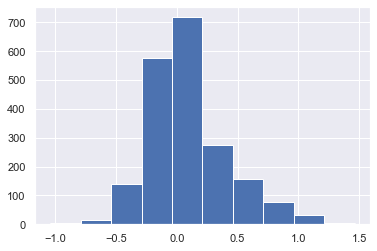

In [29]:
%%time

def getCriterion(X, Y, get_coefs=True, test_fn=False) -> np.ndarray:
    """ Get the feature selection criterion, SVM classifier coefficients. 
    
    Args:
        X (np.ndarray, 2D): feature matrix
        Y (np.ndarray, 2D): target matrix
        get_coefs (bool, optional):  Defaults to True.
        test_fn (bool, optional): Checks whether the function works correctly using 
            a randomly generated target matrix, Y_synth. Defaults to False. 
    Returns:
        coefs (np.ndarray, 1D)
    """
    assert X.shape[0] == Y.shape[0], "X and Y have different numbers of samples"
    assert Y.shape[1] == 1, "Y needs to be a column vector"
    
    if test_fn:
        # simulated target matrix, Y
        rng = np.random.RandomState(7)
        Y_synth = rng.randint(0,3, X.shape[0]).reshape(-1,1)
        
        
    global ps, coefs
    coefs, ps = [], []

    # for each column of X
    for row in X.T:
        x = row.reshape(-1, 1)

        if get_coefs:
            # Calculate classification coefficients
            model = SGDClassifier(loss='hinge') # SVM classifier
            model.fit(x, Y)
            y_pred = model.predict(x)
            coefs.append(model.coef_[0,0])

        else:
            # Calculate p-values from logit model
            # sm_model = sm.Logit(Y, sm.add_constant(x)).fit(disp=0)
            sm_model = sm.MNLogit(Y, sm.add_constant(x)).fit(disp=0)
            ps.append(sm_model.pvalues[1])
    
    if get_coefs:
        return (coefs:= np.array(coefs))
    else:
        return (ps:= np.array(ps))
        
coefs = getCriterion(X, Y)
plt.hist(coefs);

In [19]:
torch.topk(torch.Tensor(coefs), k=2000)[1]

tensor([1812,  254, 1711,  ..., 1117, 1066, 1959])

In [37]:
X = pd.read_csv("gtTypes_C.csv")
X.shape

MemoryError: Unable to allocate 4.00 KiB for an array with shape (512,) and data type int64

In [24]:
%time 
from sklearn.feature_selection import SelectKBest, chi2

X_dummy = SelectKBest(chi2, k=1200).fit_transform(X, Y)
X_dummy.shape

(1780, 1200)

- Jie Yuan1:26 PM https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/
- Jie Yuan1:30 PM https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance
- McKelvey & Zavoina https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/

0.09355327625915083

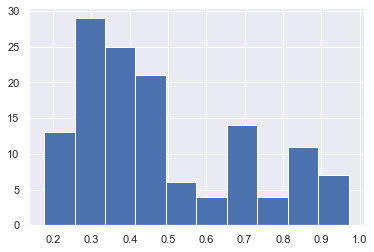

In [256]:
ps = np.abs(ps)
plt.hist(ps);
np.percentile(np.abs(coefs), 25)

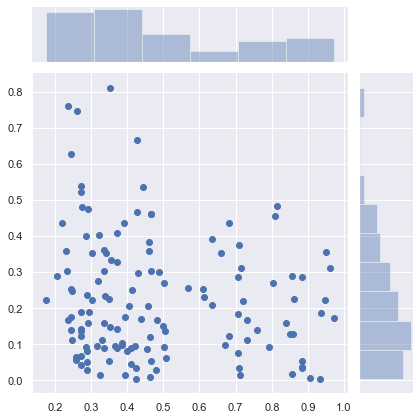

In [258]:
import seaborn as sns; sns.set()

sns.jointplot(ps, coefs, kind="scatter")

0.09355327625915083

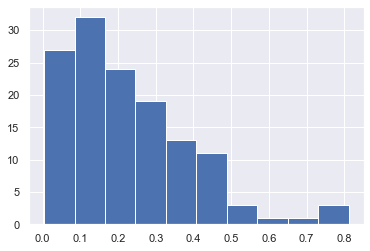

In [257]:
coefs = np.abs(coefs)
plt.hist(coefs);
np.percentile(np.abs(coefs), 25)